<a href="https://colab.research.google.com/github/sarthikac/Hybrid-CNN-LSTM-Model3-9/blob/main/Sri_CNN75_4pct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
(2115, 22, 1000)


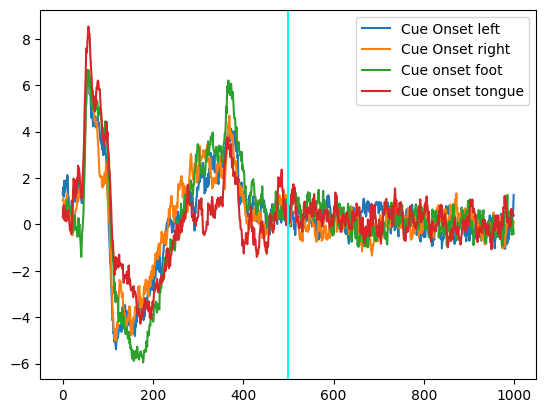

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [18]:
import os
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import datetime

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/MyDrive/cm147_Project/project')

## Loading the dataset

X_test_orig = np.load("X_test.npy")
y_test_orig = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid_orig = np.load("X_train_valid.npy")
print(X_train_valid_orig.shape)
y_train_valid_orig = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid_orig -= 769
y_test_orig -= 769

## Visualizing the data

ch_data = X_train_valid_orig[:,8,:]


class_0_ind = np.where(y_train_valid_orig == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid_orig == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid_orig == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid_orig == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])
plt.show()

print ('Training/Valid data shape: {}'.format(X_train_valid_orig.shape))
print ('Test data shape: {}'.format(X_test_orig.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid_orig.shape))
print ('Test target shape: {}'.format(y_test_orig.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

In [69]:


def train_data_prep(X,y,sub_sample,average,noise):

    total_X = None
    total_y = None

    # Trimming the data (sample,22,1000) -> (sample,22,800)
    #X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)

    # Averaging + noise
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)

    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)

    #Subsampling

    for i in range(sub_sample):

        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)

        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))


    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


def test_data_prep(X, sub_sample):

    total_X = None


    # Trimming the data (sample,22,1000) -> (sample,22,800)
    #X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)


    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)

    return total_X

def data_prep_original():
  ## Preprocessing the dataset

  X_train_valid_prep,y_train_valid_prep = train_data_prep(X_train_valid_orig,y_train_valid_orig,2,2,True)
  X_test_prep = test_data_prep(X_test_orig, 2)
  ## Random splitting and reshaping the data

  # First generating the training and validation indices using random splitting
  ind_valid = np.random.choice(8460, 800, replace=False)
  ind_train = np.array(list(set(range(8460)).difference(set(ind_valid))))

  # Creating the training and validation sets using the generated indices
  (x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid]
  (y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]
  print('Shape of training set:',x_train.shape)
  print('Shape of validation set:',x_valid.shape)
  print('Shape of training labels:',y_train.shape)
  print('Shape of validation labels:',y_valid.shape)


  # Converting the labels to categorical variables for multiclass classification
  y_train = to_categorical(y_train, 4)
  y_valid = to_categorical(y_valid, 4)
  y_test = to_categorical(y_test_orig, 4)
  print('Shape of training labels after categorical conversion:',y_train.shape)
  print('Shape of validation labels after categorical conversion:',y_valid.shape)
  print('Shape of test labels after categorical conversion:',y_test.shape)

  # Adding width of the segment to be 1
  x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
  x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
  x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
  print('Shape of training set after adding width info:',x_train.shape)
  print('Shape of validation set after adding width info:',x_valid.shape)
  print('Shape of test set after adding width info:',x_test.shape)


  # Reshaping the training and validation dataset
  x_train = np.swapaxes(x_train, 1,3)
  x_train = np.swapaxes(x_train, 1,2)
  x_valid = np.swapaxes(x_valid, 1,3)
  x_valid = np.swapaxes(x_valid, 1,2)
  x_test = np.swapaxes(x_test, 1,3)
  x_test = np.swapaxes(x_test, 1,2)
  print('Shape of training set after dimension reshaping:',x_train.shape)
  print('Shape of validation set after dimension reshaping:',x_valid.shape)
  print('Shape of test set after dimension reshaping:',x_test.shape)

  return x_train, y_train, x_valid, y_valid, x_test, y_test

def get_train_data(train_sub_ids=None, test_sub_ids=None, timebins=1000, sub_sample = 2, valid_sample = 0.1):
  X_train_valid = X_train_valid_orig
  y_train_valid = y_train_valid_orig
  X_test = X_test_orig
  y_test = y_test_orig
  ## Preprocessing the dataset
  if train_sub_ids != None:
    X_train_valid = X_train_valid[np.where(person_train_valid == [train_sub_ids])[0]]
    y_train_valid = y_train_valid[np.where(person_train_valid == [train_sub_ids])[0]]

  if test_sub_ids != None:
    X_test = X_test[np.where(person_test == [test_sub_ids])[0]]
    y_test = y_test[np.where(person_test == [test_sub_ids])[0]]

  if timebins < 1000:
    X_train_valid = X_train_valid.reshape(X_train_valid.shape[0], X_train_valid.shape[1], timebins)
    y_train_valid = y_train_valid.reshape(y_train_valid.shape[0], y_train_valid.shape[1], timebins)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], timebins)
    y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], timebins)

  ## Preprocessing the dataset

  X_train_valid_prep,y_train_valid_prep = train_data_prep(X_train_valid,y_train_valid,sub_sample,sub_sample,True)
  X_test_prep = test_data_prep(X_test, sub_sample)
  ## Random splitting and reshaping the data

  # First generating the training and validation indices using random splitting
  train_valid_size=len(X_train_valid) * (sub_sample**2)
  ind_valid = np.random.choice(train_valid_size, int(train_valid_size*valid_sample), replace=False)
  ind_train = np.array(list(set(range(train_valid_size)).difference(set(ind_valid))))

  # Creating the training and validation sets using the generated indices
  (x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid]
  (y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]
  print('Shape of training set:',x_train.shape)
  print('Shape of validation set:',x_valid.shape)
  print('Shape of training labels:',y_train.shape)
  print('Shape of validation labels:',y_valid.shape)


  # Converting the labels to categorical variables for multiclass classification
  y_train = to_categorical(y_train, 4)
  y_valid = to_categorical(y_valid, 4)
  y_test = to_categorical(y_test, 4)
  print('Shape of training labels after categorical conversion:',y_train.shape)
  print('Shape of validation labels after categorical conversion:',y_valid.shape)
  print('Shape of test labels after categorical conversion:',y_test.shape)

  # Adding width of the segment to be 1
  x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
  x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
  x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
  print('Shape of training set after adding width info:',x_train.shape)
  print('Shape of validation set after adding width info:',x_valid.shape)
  print('Shape of test set after adding width info:',x_test.shape)


  # Reshaping the training and validation dataset
  x_train = np.swapaxes(x_train, 1,3)
  x_train = np.swapaxes(x_train, 1,2)
  x_valid = np.swapaxes(x_valid, 1,3)
  x_valid = np.swapaxes(x_valid, 1,2)
  x_test = np.swapaxes(x_test, 1,3)
  x_test = np.swapaxes(x_test, 1,2)
  print('Shape of training set after dimension reshaping:',x_train.shape)
  print('Shape of validation set after dimension reshaping:',x_valid.shape)
  print('Shape of test set after dimension reshaping:',x_test.shape)

  return x_train, y_train, x_valid, y_valid, x_test, y_test

def build_cnn(input_shape, kernel_size, activation, layers=2, filters=50):
  # Building the CNN model using sequential class
  model = Sequential()

  # Conv. block 1
  model.add(Conv2D(filters=filters, kernel_size = kernel_size, padding='same', activation=activation, input_shape=input_shape,
                   kernel_regularizer=keras.regularizers.L1L2(l1=0, l2=0.01)))
  model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
  model.add(BatchNormalization())
  model.add(Dropout(0.6))

  for i in range(1,layers):
    # Conv. block 2....
    model.add(Conv2D(filters=(i+1)*50, kernel_size = kernel_size, padding='same', activation=activation,
                    kernel_regularizer=keras.regularizers.L1L2(l1=0, l2=0.01)))
    model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.6))

  # Output layer with Softmax activation
  model.add(Flatten()) # Flattens the input
  model.add(Dense(4, activation='softmax', kernel_regularizer=keras.regularizers.L1L2(l1=0, l2=0.01)))


  # Printing the model summary
  model.summary()
  return model

def configure_compile_model(model,optimizer,loss_fn,learning_rate):
  if (optimizer=="SGD"):
    model_optimizer = keras.optimizers.SGD(learning_rate = learning_rate, weight_decay=0.01)
  elif (optimizer=="Adam"):
    model_optimizer = keras.optimizers.Adam(learning_rate = learning_rate, epsilon=1e-8, weight_decay=0.01)

  model.compile(loss=loss_fn,
                 optimizer=model_optimizer,
                 metrics=['accuracy'])
  return model

def fit_model(model,batch_size,epochs):
  callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)
  return model.fit(x_train,
             y_train,
             batch_size=batch_size,
             epochs=epochs,#callbacks =[callback],
             validation_data=(x_valid, y_valid), verbose=True) #verbose=0) #

def plot_graph(arch):
  plt.plot(model_results.history['accuracy'])
  plt.plot(model_results.history['val_accuracy'])
  plt.title(f'{arch} Model accuracy trajectory')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  # Plotting loss trajectory
  plt.plot(model_results.history['loss'],'o')
  plt.plot(model_results.history['val_loss'],'o')
  plt.title(f'{arch} Model loss trajectory')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

def test_model(arch):
  global score,model
  score = model.evaluate(x_test, y_test, verbose=0)
  print(f'Test accuracy of the {arch} Model: {score[1]}')

In [ ]:
#def get_train_data(train_sub_ids=None, test_sub_ids=None, timebins=1000, sub_sample = 2)
#x_train, y_train, x_valid, y_valid, x_test, y_test = data_prep_original()
x_train, y_train, x_valid, y_valid, x_test, y_test = get_train_data()
#x_train, y_train, x_valid, y_valid, x_test, y_test = get_train_data([1][0])

Started at:  03/13/2024, 02:29:42
Shape of X after trimming: (2115, 22, 1000)
Shape of X after maxpooling: (2115, 22, 500)
Shape of X after averaging+noise and concatenating: (4230, 22, 500)
Shape of X after subsampling and concatenating: (8460, 22, 500)
Shape of Y: (8460,)
Shape of X after trimming: (443, 22, 1000)
Shape of X after maxpooling: (443, 22, 500)
Shape of training set: (7191, 22, 500)
Shape of validation set: (1269, 22, 500)
Shape of training labels: (7191,)
Shape of validation labels: (1269,)
Shape of training labels after categorical conversion: (7191, 4)
Shape of validation labels after categorical conversion: (1269, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (7191, 22, 500, 1)
Shape of validation set after adding width info: (1269, 22, 500, 1)
Shape of test set after adding width info: (443, 22, 500, 1)
Shape of training set after dimension reshaping: (7191, 500, 1, 22)
Shape of validation set after dim

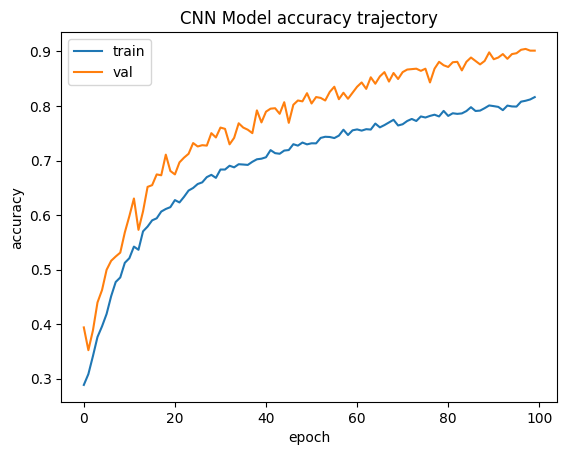

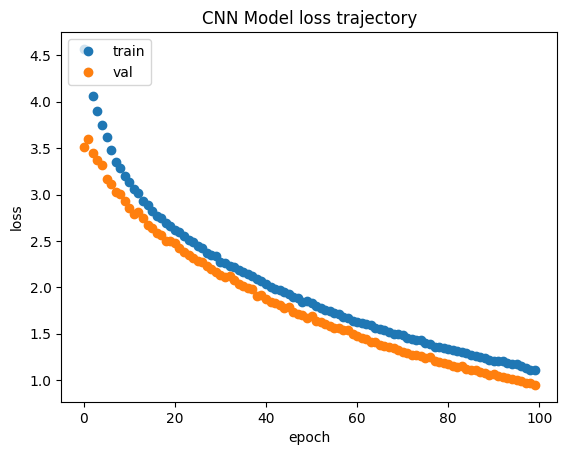

Test accuracy of the CNN Model: 0.7539503574371338
Ended at:  03/13/2024, 02:32:43
{'architecture': 'CNN', 'optimizer': 'SGD', 'loss_fn': 'categorical_crossentropy', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'kernel_size': (5, 5), 'activation': 'elu', 'layers': 3, 'filters': 50, 'Timebins': 1000, 'ValdSamples': 0.15, 'dropout': 0.6, 'epsilon': 1e-08, 'decay': 0.01, 'Preprocessing': 'split valid/train before prep', 'trainSubjects': [0, 1, 2, 3, 4, 5, 6, 7, 8], 'testSubjects': [0, 1, 2, 3, 4, 5, 6, 7, 8], 'subSample': 2, 'Train Accuracy': 0.8162981271743774, 'Validation Accuracy': 0.9014972448348999, 'Test Accuracy': 0.7539503574371338, 'StartTime': '03/13/2024, 02:29:42', 'EndTime': '03/13/2024, 02:32:43', 'ElapsedTime': '0:03:01'}


In [76]:
params={}
params['architecture']="CNN"
params['optimizer']="SGD"   #"Adam"
params['loss_fn']="categorical_crossentropy"
params['learning_rate']=1e-3
params['epochs']=100
params['batch_size']=32
params['kernel_size']=(5,5)
params['activation']="elu"
params['layers']=3
params['filters']=50
params['Timebins']=1000
params['ValdSamples']=0.15
params['dropout']=0.6
params['epsilon']=1e-8
params['decay']=0.01
params['Preprocessing']='split valid/train before prep'
params['trainSubjects']=[0,1,2,3,4,5,6,7,8]
params['testSubjects']=[0,1,2,3,4,5,6,7,8]
params['subSample']=2

#now.strftime("%m/%d/%Y, %H:%M:%S")

start_tm=datetime.datetime.now().replace(microsecond=0)
print('Started at: ',start_tm.strftime("%m/%d/%Y, %H:%M:%S"))
x_train, y_train, x_valid, y_valid, x_test, y_test = get_train_data(params['trainSubjects'],params['testSubjects'],params['Timebins'],params['subSample'],params['ValdSamples'])

model = build_cnn(x_train[0].shape,params['kernel_size'],params['activation'],params['layers'],params['filters'])
model = configure_compile_model(model,params['optimizer'],params['loss_fn'],params['learning_rate'])
model_results = fit_model(model,params['batch_size'],params['epochs'])
plot_graph(params['architecture'])

score = model.evaluate(x_test, y_test, verbose=0)
print(f'Test accuracy of the {params["architecture"]} Model: {score[1]}')
params['Train Accuracy'] = model_results.history['accuracy'][-1]
params['Validation Accuracy'] = model_results.history['val_accuracy'][-1]
params['Test Accuracy']=score[1]
end_tm=datetime.datetime.now().replace(microsecond=0)
print('Ended at: ',end_tm.strftime("%m/%d/%Y, %H:%M:%S"))
params['StartTime']=start_tm.strftime("%m/%d/%Y, %H:%M:%S")
params['EndTime']=end_tm.strftime("%m/%d/%Y, %H:%M:%S")
params['ElapsedTime']=str(end_tm - start_tm)
print(params)
params['kernel_size']=', '.join(map(str, params['kernel_size']))
params['trainSubjects']=', '.join(map(str, params['trainSubjects']))
params['testSubjects']=', '.join(map(str, params['testSubjects']))
res_df = pd.DataFrame(params, index=[0])
# res_df2 = pd.DataFrame(params, index=[1])
# res_df = pd.concat([res_df, res_df2], axis=0)
# print(res_df)
os.chdir('/content/drive/MyDrive')
with open("results_1.csv", 'a') as f:
    res_df.to_csv(f, mode='a', index=False, header=f.tell()==0)

In [31]:
score = model.evaluate(x_test, y_test, verbose=0)
print(f'Test accuracy of the {arch} Model: {score[1]}')

Test accuracy of the CNN Model: 0.5101580023765564
